# Импортируем необходимые библиотеки

In [1]:
pip install scikeras

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler, StandardScaler, Normalizer, LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.multioutput import MultiOutputRegressor
from sklearn.linear_model import LinearRegression
from sklearn.svm import SVR
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization, Normalization
from tensorflow.keras.callbacks import EarlyStopping
import tensorflow as tf
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.metrics import RootMeanSquaredError
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import mean_absolute_error, r2_score
from tensorflow.keras.models import load_model

# Загрузка данных

In [3]:
df_bp = pd.read_excel('X_bp.xlsx')
df_nup = pd.read_excel('X_nup.xlsx')

# Признаки и целевые переменные

In [4]:
features = [
    'Угол нашивки, град',
    'Шаг нашивки',
    'Плотность нашивки',
    'Соотношение матрица-наполнитель',
    'Плотность, кг/м3',
    'модуль упругости, ГПа',
    'Количество отвердителя, м.%',
    'Содержание эпоксидных групп,%_2',
    'Температура вспышки, С_2',
    'Поверхностная плотность, г/м2',
    'Потребление смолы, г/м2'
]

targets = [
    'Модуль упругости при растяжении, ГПа',
    'Прочность при растяжении, МПа'
]

# Объединение данных по индексу

In [5]:
data = pd.merge(df_bp, df_nup, left_index=True, right_index=True, how='inner')

# Приведем столбец "Угол нашивки" к значениям 0 и 1 и integer


In [6]:
data = data.replace({'Угол нашивки, град': {0.0 : 0, 90.0 : 1}})
data['Угол нашивки, град'] = data['Угол нашивки, град'].astype(int)

# Удаления лишних столбцов

In [7]:
data = data[data.columns.drop(list(data.filter(regex='Unnamed: 0_x')))]
data = data[data.columns.drop(list(data.filter(regex='Unnamed: 0_y')))]


# Проверим на пропущенные данные



In [8]:
data.isnull().sum()

Соотношение матрица-наполнитель         0
Плотность, кг/м3                        0
модуль упругости, ГПа                   0
Количество отвердителя, м.%             0
Содержание эпоксидных групп,%_2         0
Температура вспышки, С_2                0
Поверхностная плотность, г/м2           0
Модуль упругости при растяжении, ГПа    0
Прочность при растяжении, МПа           0
Потребление смолы, г/м2                 0
Угол нашивки, град                      0
Шаг нашивки                             0
Плотность нашивки                       0
dtype: int64

# Проверим датасет на дубликаты

In [9]:
data.duplicated().sum()

np.int64(0)

# Проверим, как выглядят данные

In [10]:
data.head()

Соотношение матрица-наполнитель  Плотность, кг/м3  модуль упругости, ГПа  \
0                         1.857143            2030.0             738.736842   
1                         1.857143            2030.0             738.736842   
2                         1.857143            2030.0             738.736842   
3                         1.857143            2030.0             738.736842   
4                         2.771331            2030.0             753.000000   

   Количество отвердителя, м.%  Содержание эпоксидных групп,%_2  \
0                        30.00                        22.267857   
1                        50.00                        23.750000   
2                        49.90                        33.000000   
3                       129.00                        21.250000   
4                       111.86                        22.267857   

   Температура вспышки, С_2  Поверхностная плотность, г/м2  \
0                100.000000                          210.0   
1                284.615385                          210.0   
2                284.615385                          210.0   
3                300.000000                          210.0   
4                284.615385                          210.0   

   Модуль упругости при растяжении, ГПа  Прочность при растяжении, МПа  \
0                                  70.0                         3000.0   
1                                  70.0                         3000.0   
2                                  70.0                         3000.0   
3                                  70.0                         3000.0   
4                                  70.0                         3000.0   

   Потребление смолы, г/м2  Угол нашивки, град  Шаг нашивки  Плотность нашивки  
0                    220.0                   0          4.0               57.0  
1                    220.0                   0          4.0               60.0  
2                    220.0                   0          4.0               70.0  
3                    220.0                   0          5.0               47.0  
4                    220.0                   0          5.0               57.0

# Описание статистики

In [11]:
data.describe()

Соотношение матрица-наполнитель  Плотность, кг/м3  \
count                      1023.000000       1023.000000   
mean                          2.930366       1975.734888   
std                           0.913222         73.729231   
min                           0.389403       1731.764635   
25%                           2.317887       1924.155467   
50%                           2.906878       1977.621657   
75%                           3.552660       2021.374375   
max                           5.591742       2207.773481   

       модуль упругости, ГПа  Количество отвердителя, м.%  \
count            1023.000000                  1023.000000   
mean              739.923233                   110.570769   
std               330.231581                    28.295911   
min                 2.436909                    17.740275   
25%               500.047452                    92.443497   
50%               739.664328                   110.564840   
75%               961.812526                   129.730366   
max              1911.536477                   198.953207   

       Содержание эпоксидных групп,%_2  Температура вспышки, С_2  \
count                      1023.000000               1023.000000   
mean                         22.244390                285.882151   
std                           2.406301                 40.943260   
min                          14.254985                100.000000   
25%                          20.608034                259.066528   
50%                          22.230744                285.896812   
75%                          23.961934                313.002106   
max                          33.000000                413.273418   

       Поверхностная плотность, г/м2  Модуль упругости при растяжении, ГПа  \
count                    1023.000000                           1023.000000   
mean                      482.731833                             73.328571   
std                       281.314690                              3.118983   
min                         0.603740                             64.054061   
25%                       266.816645                             71.245018   
50%                       451.864365                             73.268805   
75%                       693.225017                             75.356612   
max                      1399.542362                             82.682051   

       Прочность при растяжении, МПа  Потребление смолы, г/м2  \
count                    1023.000000              1023.000000   
mean                     2466.922843               218.423144   
std                       485.628006                59.735931   
min                      1036.856605                33.803026   
25%                      2135.850448               179.627520   
50%                      2459.524526               219.198882   
75%                      2767.193119               257.481724   
max                      3848.436732               414.590628   

       Угол нашивки, град  Шаг нашивки  Плотность нашивки  
count         1023.000000  1023.000000        1023.000000  
mean             0.491691     6.899222          57.153929  
std              0.500175     2.563467          12.350969  
min              0.000000     0.000000           0.000000  
25%              0.000000     5.080033          49.799212  
50%              0.000000     6.916144          57.341920  
75%              1.000000     8.586293          64.944961  
max              1.000000    14.440522         103.988901

In [12]:
data = data.replace({'Угол нашивки, град': {0.0 : 0, 90.0 : 1}})
data['Угол нашивки, град'] = data['Угол нашивки, град'].astype(int)

# Очистка данных от выбросов в данном примере удалим значения, которые явно выходят за пределы нормального распределения

In [13]:
data_clean = data[(np.abs(data - data.mean()) / data.std()) < 3].dropna()

# Удаление выбросов на основе IQR

In [14]:
Q1 = data[features].quantile(0.25)
Q3 = data[features].quantile(0.75)
IQR = Q3 - Q1

# Убираем строки, где значения выходят за пределы 1.5 * IQR
data = data[~((data[features] < (Q1 - 1.5 * IQR)) | (data[features] > (Q3 + 1.5 * IQR))).any(axis=1)]

# Нормализация данных с использованием MinMaxScaler

In [15]:
scaler = MinMaxScaler()
data_normalized = pd.DataFrame(scaler.fit_transform(data_clean), columns=data_clean.columns)

# Нарисуем ящики с усами (боксплоты)

<ipython-input-16-1674748863>:5: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot(pd.DataFrame(scaler.transform(data)), labels = data.columns,patch_artist = True, meanline = True, vert = False, boxprops = dict(facecolor = 'g', color = 'y'),medianprops = dict(color = 'lime'), whiskerprops = dict(color="g"), capprops = dict(color = "black"), flierprops = dict(color = "y", markeredgecolor = "maroon"))


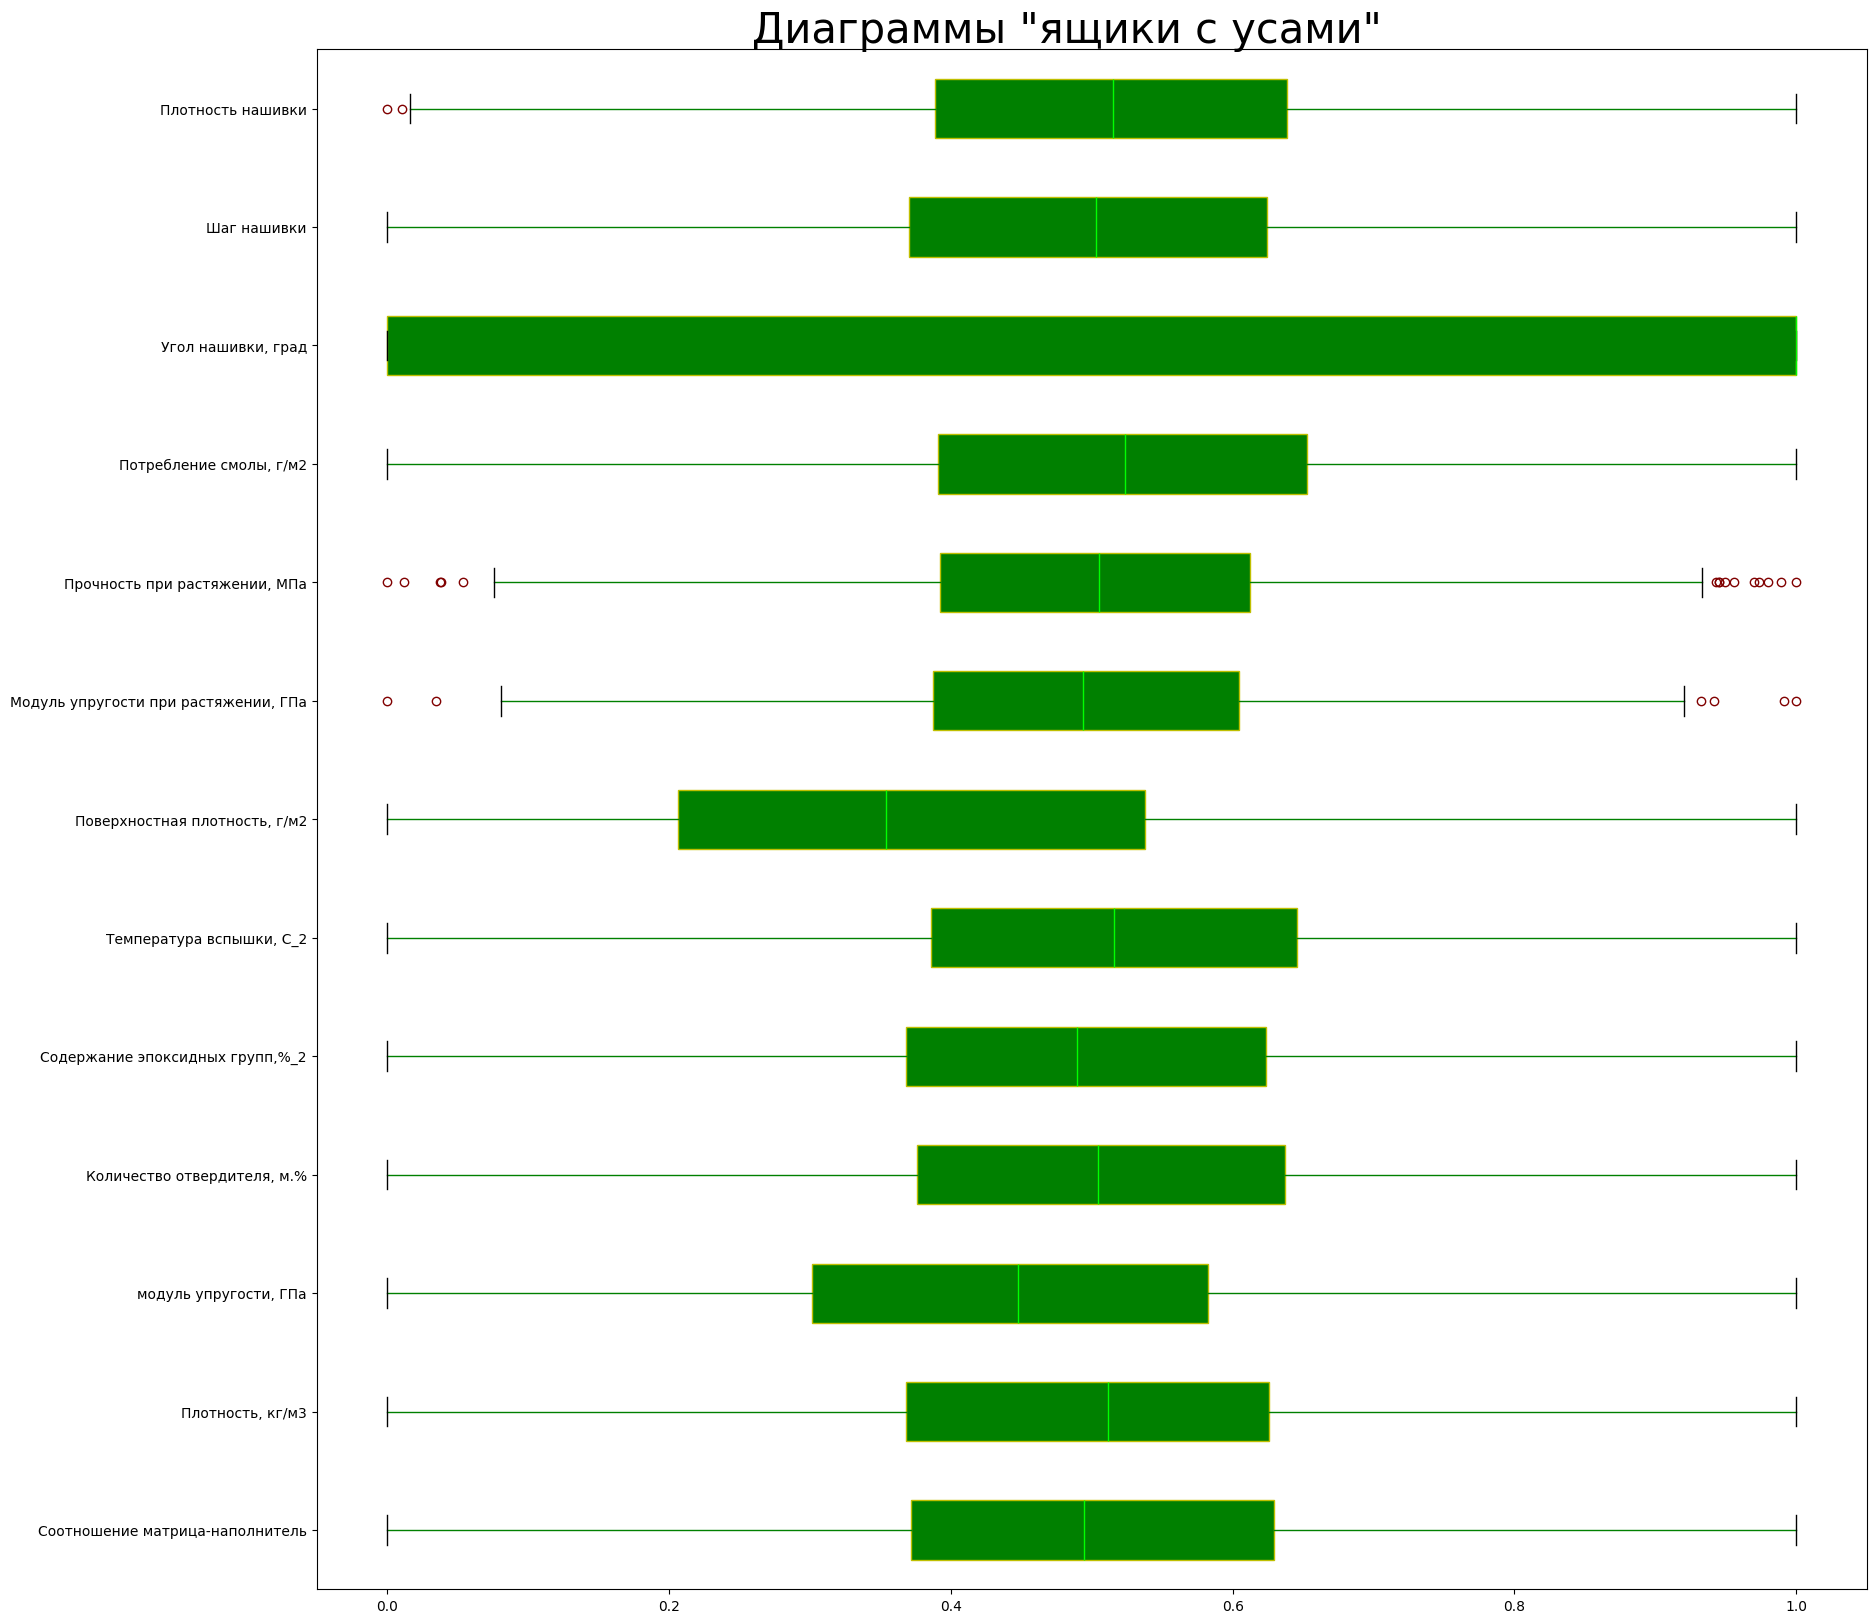

In [16]:
scaler.fit(data)
plt.figure(figsize = (20, 20))
plt.suptitle('Диаграммы "ящики с усами"', y = 0.9 ,
             fontsize = 30)
plt.boxplot(pd.DataFrame(scaler.transform(data)), labels = data.columns,patch_artist = True, meanline = True, vert = False, boxprops = dict(facecolor = 'g', color = 'y'),medianprops = dict(color = 'lime'), whiskerprops = dict(color="g"), capprops = dict(color = "black"), flierprops = dict(color = "y", markeredgecolor = "maroon"))
plt.show()

# Проверим, как изменились данные после нормализации

In [18]:
data.head()

Соотношение матрица-наполнитель  Плотность, кг/м3  модуль упругости, ГПа  \
1                         1.857143            2030.0             738.736842   
3                         1.857143            2030.0             738.736842   
4                         2.771331            2030.0             753.000000   
5                         2.767918            2000.0             748.000000   
6                         2.569620            1910.0             807.000000   

   Количество отвердителя, м.%  Содержание эпоксидных групп,%_2  \
1                        50.00                        23.750000   
3                       129.00                        21.250000   
4                       111.86                        22.267857   
5                       111.86                        22.267857   
6                       111.86                        22.267857   

   Температура вспышки, С_2  Поверхностная плотность, г/м2  \
1                284.615385                          210.0   
3                300.000000                          210.0   
4                284.615385                          210.0   
5                284.615385                          210.0   
6                284.615385                          210.0   

   Модуль упругости при растяжении, ГПа  Прочность при растяжении, МПа  \
1                                  70.0                         3000.0   
3                                  70.0                         3000.0   
4                                  70.0                         3000.0   
5                                  70.0                         3000.0   
6                                  70.0                         3000.0   

   Потребление смолы, г/м2  Угол нашивки, град  Шаг нашивки  Плотность нашивки  
1                    220.0                   0          4.0               60.0  
3                    220.0                   0          5.0               47.0  
4                    220.0                   0          5.0               57.0  
5                    220.0                   0          5.0               60.0  
6                    220.0                   0          5.0               70.0

In [17]:
data_normalized.head()

Соотношение матрица-наполнитель  Плотность, кг/м3  модуль упругости, ГПа  \
0                         0.282131          0.601381               0.447061   
1                         0.282131          0.601381               0.447061   
2                         0.457857          0.601381               0.455721   
3                         0.457201          0.527898               0.452685   
4                         0.419084          0.307448               0.488508   

   Количество отвердителя, м.%  Содержание эпоксидных групп,%_2  \
0                     0.123047                         0.607435   
1                     0.608021                         0.418887   
2                     0.502800                         0.495653   
3                     0.502800                         0.495653   
4                     0.502800                         0.495653   

   Температура вспышки, С_2  Поверхностная плотность, г/м2  \
0                  0.482823                        0.16223   
1                  0.549664                        0.16223   
2                  0.482823                        0.16223   
3                  0.482823                        0.16223   
4                  0.482823                        0.16223   

   Модуль упругости при растяжении, ГПа  Прочность при растяжении, МПа  \
0                              0.319194                       0.698235   
1                              0.319194                       0.698235   
2                              0.319194                       0.698235   
3                              0.319194                       0.698235   
4                              0.319194                       0.698235   

   Потребление смолы, г/м2  Угол нашивки, град  Шаг нашивки  Плотность нашивки  
0                 0.517418                 0.0     0.275109           0.544652  
1                 0.517418                 0.0     0.344539           0.365074  
2                 0.517418                 0.0     0.344539           0.503211  
3                 0.517418                 0.0     0.344539           0.544652  
4                 0.517418                 0.0     0.344539           0.682789

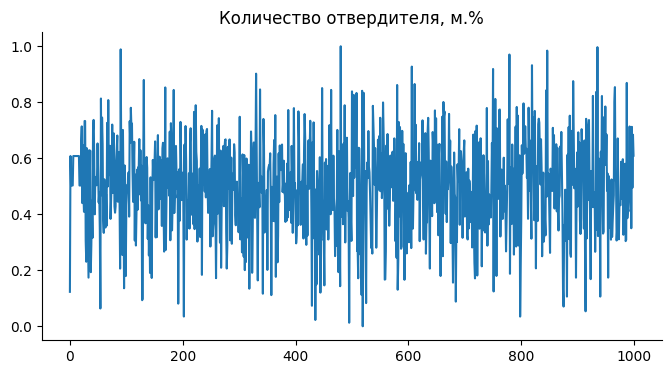

In [19]:
from matplotlib import pyplot as plt
data_normalized['Количество отвердителя, м.%'].plot(kind='line', figsize=(8, 4), title='Количество отвердителя, м.%')
plt.gca().spines[['top', 'right']].set_visible(False)

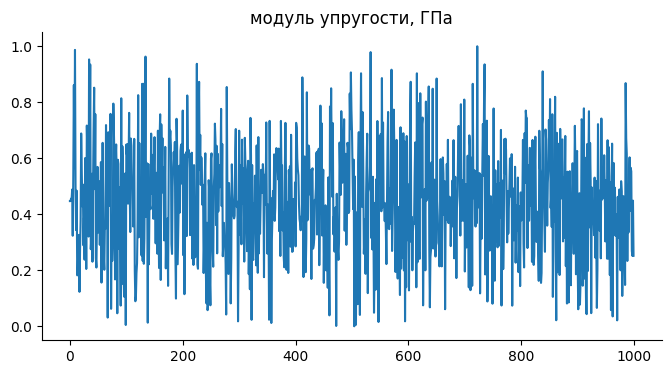

In [20]:
from matplotlib import pyplot as plt
data_normalized['модуль упругости, ГПа'].plot(kind='line', figsize=(8, 4), title='модуль упругости, ГПа')
plt.gca().spines[['top', 'right']].set_visible(False)

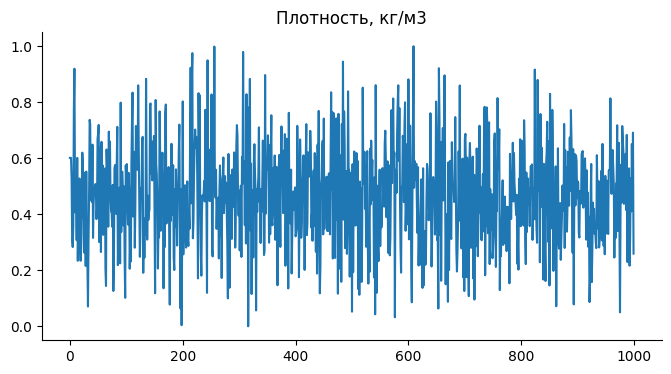

In [21]:
from matplotlib import pyplot as plt
data_normalized['Плотность, кг/м3'].plot(kind='line', figsize=(8, 4), title='Плотность, кг/м3')
plt.gca().spines[['top', 'right']].set_visible(False)

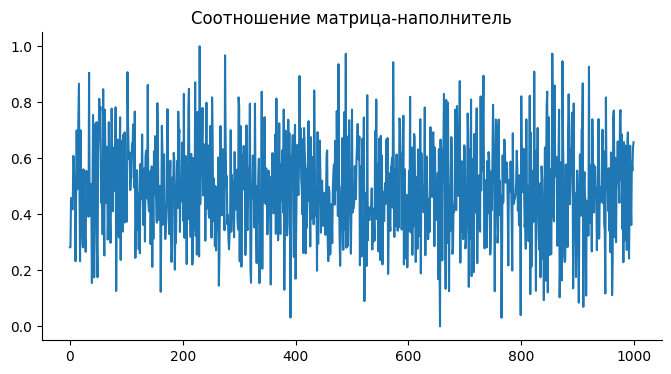

In [22]:
from matplotlib import pyplot as plt
data_normalized['Соотношение матрица-наполнитель'].plot(kind='line', figsize=(8, 4), title='Соотношение матрица-наполнитель')
plt.gca().spines[['top', 'right']].set_visible(False)

# Попарные графики рассеяния точек - скаттерплоты

<function matplotlib.pyplot.show(close=None, block=None)>

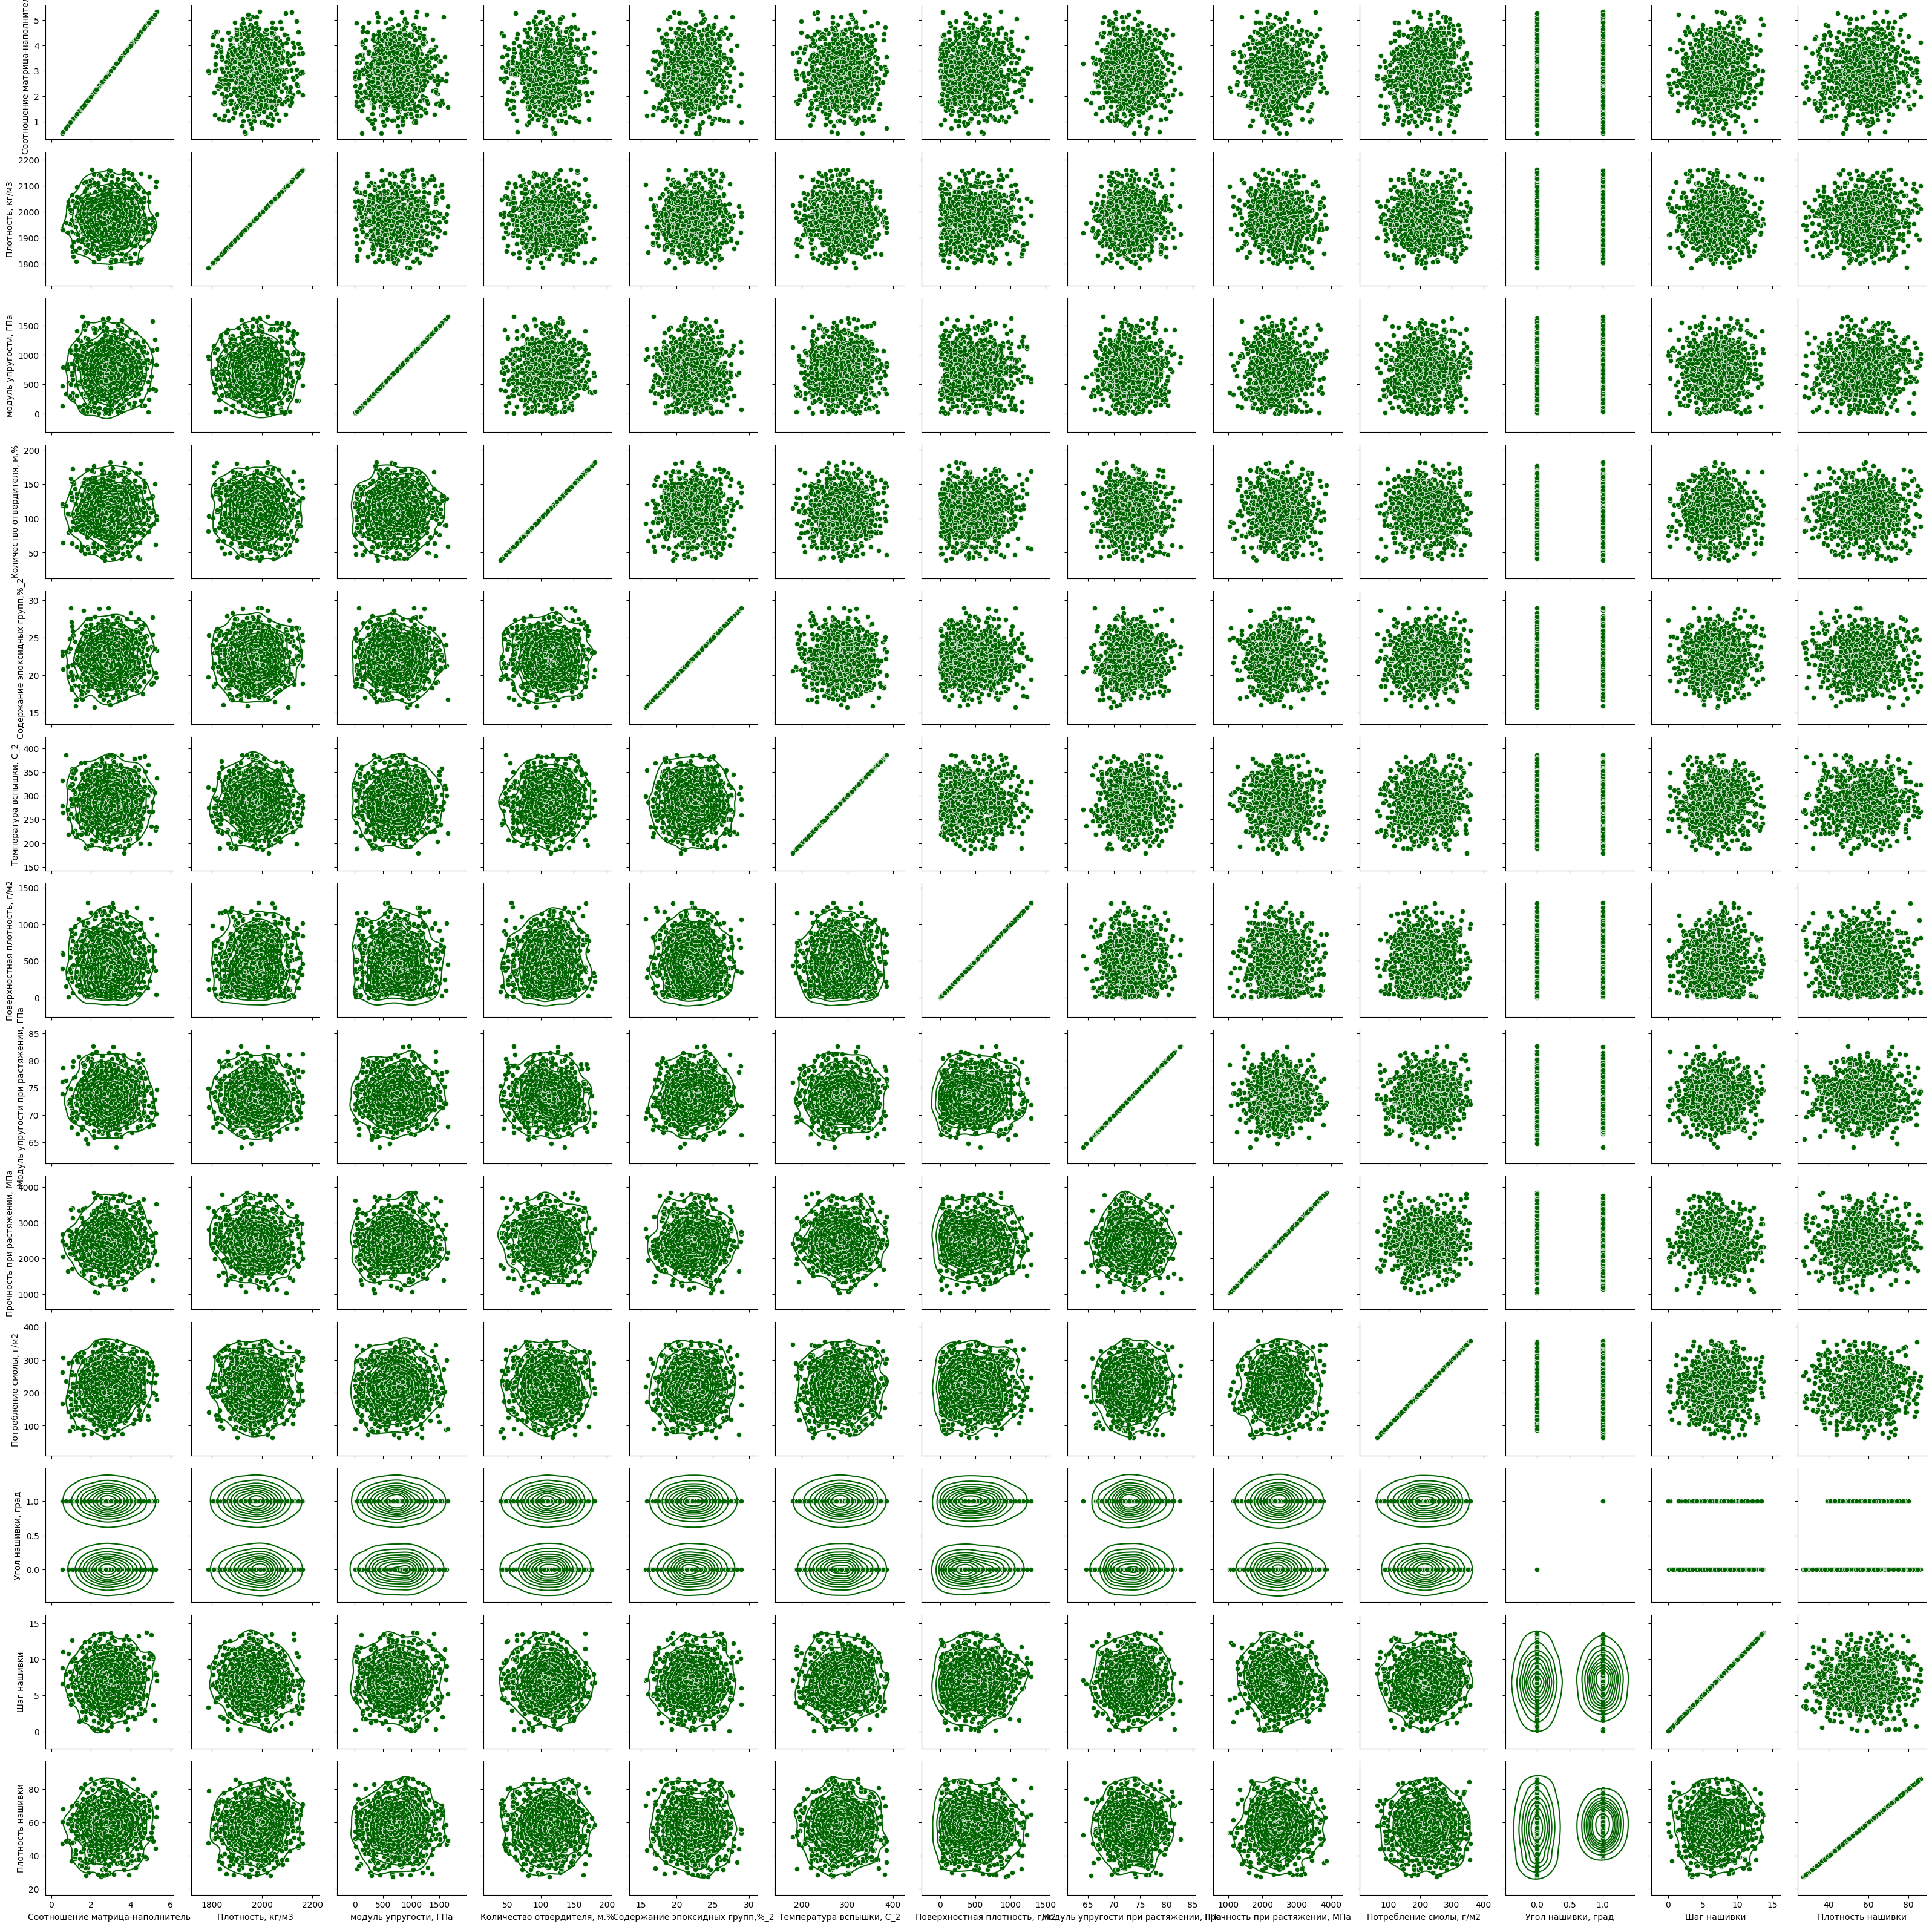

In [23]:
g = sns.PairGrid(data[data.columns])
g.map(sns.scatterplot, color = 'darkgreen')
g.map_upper(sns.scatterplot, color = 'darkgreen')
g.map_lower(sns.kdeplot, color = 'darkgreen')
plt.show

# Построим карту плотности распределений для всех числовых колонок

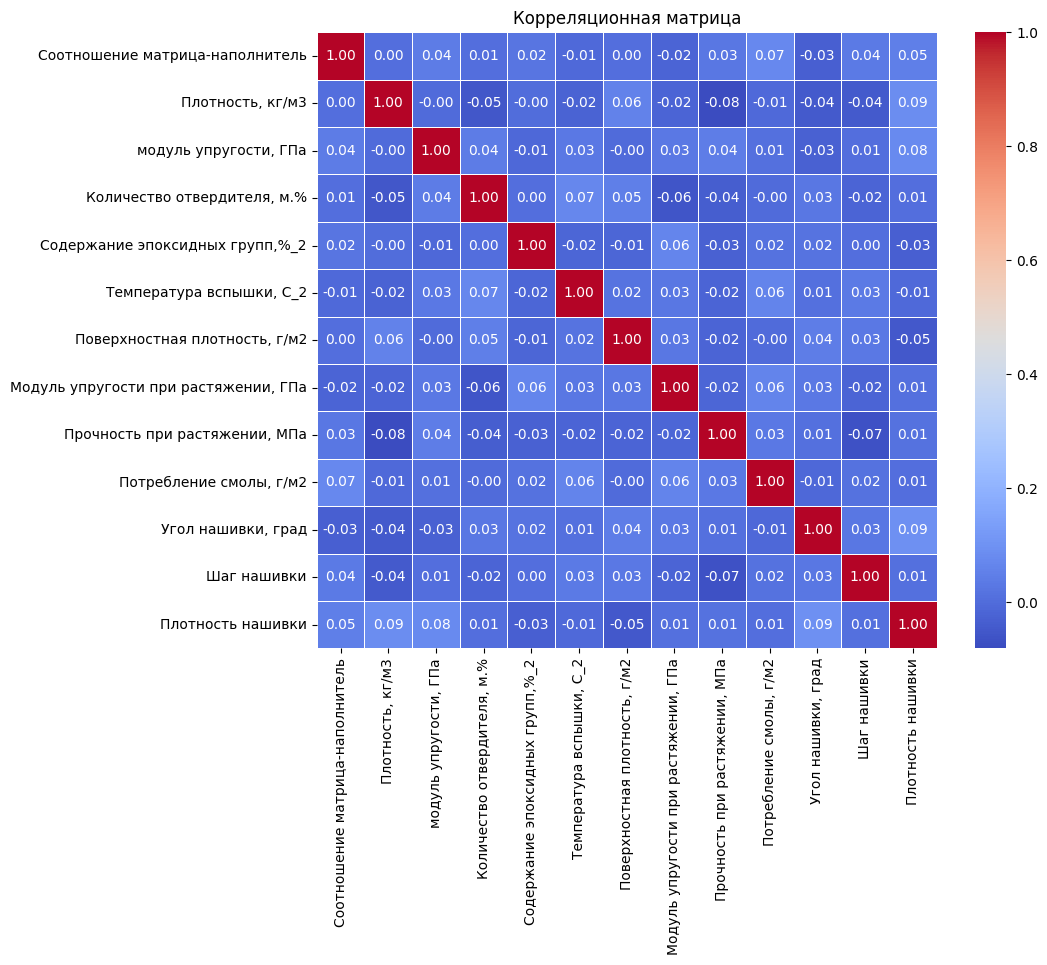

In [24]:
plt.figure(figsize=(10, 8))
sns.heatmap(data.corr(), annot=True, cmap="coolwarm", fmt=".2f", linewidths=0.5)
plt.title("Корреляционная матрица")
plt.show()

# Гистограммы для анализа распределений переменных

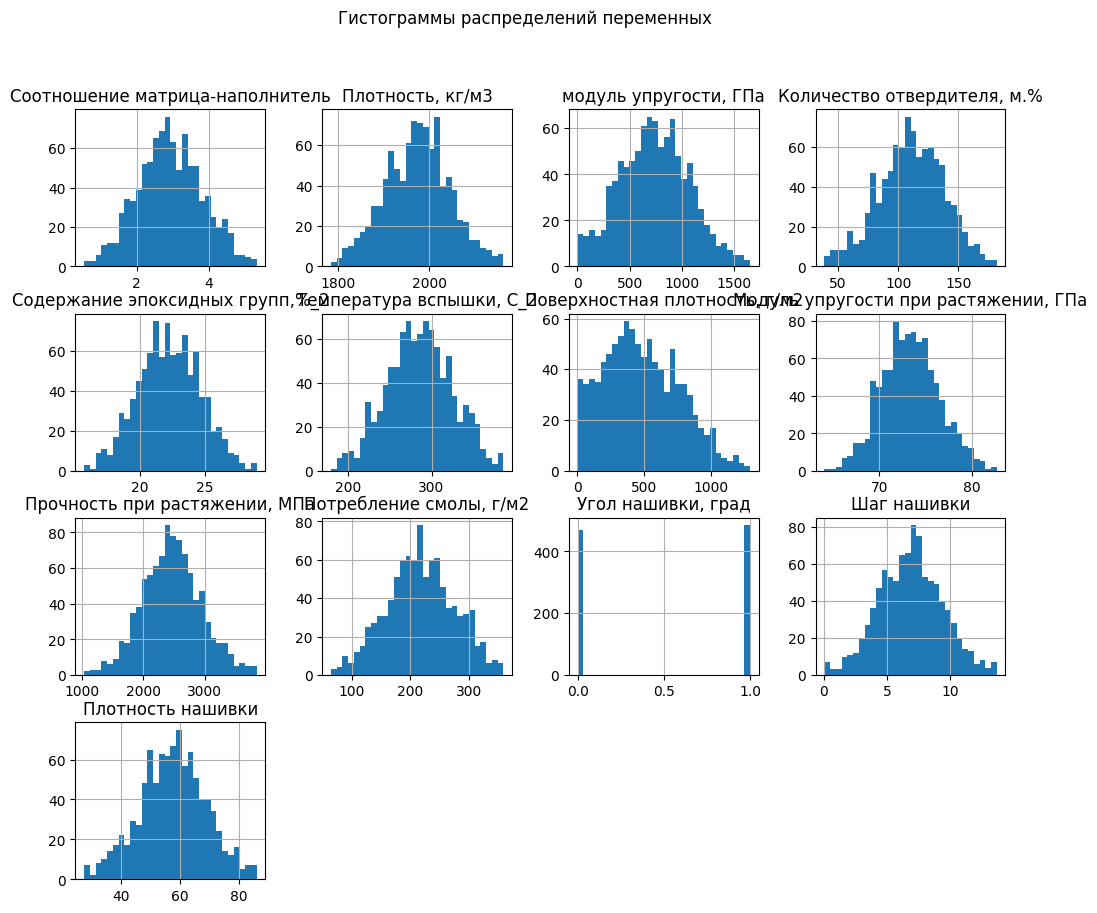

In [26]:
data.hist(bins=30, figsize=(12, 10))
plt.suptitle("Гистограммы распределений переменных")
plt.show()

При проведении анализа выявлены параметры близкие к нормальному:

* Соотношение матрица-наполнитель;
* Плотность, кг/м3; Модуль упругости, Гпа;
* Количество отвердителя, м.%;
* Содержание эпоксидных групп,%_2;
* Температура вспышки, С_2;
* Поверхностная плотность, г/м2;
* Модуль упругости при растяжении, Гпа;
* Прочность при растяжении, Мпа;
* Потребление смолы, г/м2;
* Шаг нашивки;
* Плотность нашивки.


# Визуализация корреляционной матрицы с помощью тепловой карты

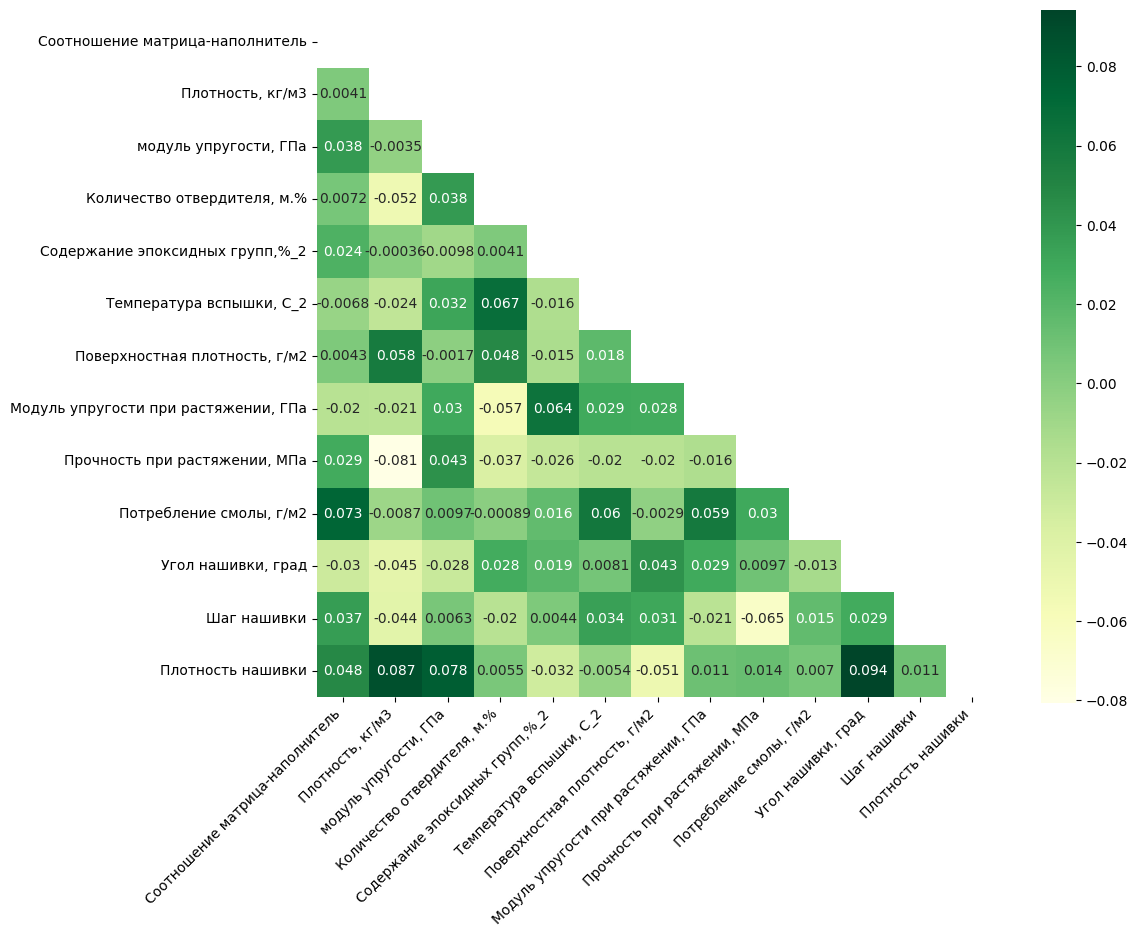

In [27]:
mask = np.triu(data.corr())
f, ax = plt.subplots(figsize = (11, 9))
sns.heatmap(data.corr(), mask = mask, annot = True, square = True, cmap = 'YlGn')
plt.xticks(rotation = 45, ha='right')
plt.show()

Максимальная корреляция между плотностью нашивки и углом нашивки составляет 0.089, что говорит об отсутствии зависимости между этими данными.

Корреляция между всеми параметрами очень близка к 0, что говорит об отсутствии корреляционных связей между переменными.
График корреляции подтверждает данные теории композитных материалов. Мы видим, что на качество материла влияет температура вспышки и количество отвердителя из-за взаимодействия отвердителя с матрицей и наполнителем под влиянием температуры. Угол нашивки и плотность нашивки несомненно оказывают влияние на свойства материала. А потребление смолы и соотношение матрицы-наполнителя, плотности и плотности нашивки, модуля упругости и плотности нашивки имеют не особенно выраженную корреляцию.

# Задача регрессии методом машинного обучения

# Определяем признаки и целевые переменные

In [28]:
feature = data[features]
target = data[targets]

# Разделение данных на тренировочную и тестовую выборки

In [29]:
X_train, X_test, y_train, y_test = train_test_split(feature, target, test_size=0.2, random_state=42)

# Обучаем RandomForestRegressor

In [30]:
rf_model = RandomForestRegressor(n_estimators=100, random_state=42)
rf_model.fit(X_train, y_train)

RandomForestRegressor(random_state=42)

# Прогнозируем и оцениваем модель


In [31]:
rf_predictions = rf_model.predict(X_test)
rf_mse = mean_squared_error(y_test, rf_predictions)
rf_r2 = r2_score(y_test, rf_predictions)

In [32]:
print(f"Random Forest - MSE: {rf_mse:.4f}, R²: {rf_r2:.4f}")

Random Forest - MSE: 126026.3157, R²: -0.0125


# Обучаем GradientBoostingRegressor


In [33]:
gb_model = GradientBoostingRegressor(n_estimators=100, random_state=42)
multioutput_model = MultiOutputRegressor(gb_model)

# Обучаем модель

In [34]:
multioutput_model.fit(X_train, y_train)

MultiOutputRegressor(estimator=GradientBoostingRegressor(random_state=42))

# Прогнозируем и оцениваем модель


In [35]:
gb_predictions = multioutput_model.predict(X_test)

# Оценка результатов модели

In [36]:
from sklearn.metrics import mean_squared_error, r2_score

mse_1 = mean_squared_error(y_test.iloc[:, 0], gb_predictions[:, 0])
mse_2 = mean_squared_error(y_test.iloc[:, 1], gb_predictions[:, 1])

r2_1 = r2_score(y_test.iloc[:, 0], gb_predictions[:, 0])
r2_2 = r2_score(y_test.iloc[:, 1], gb_predictions[:, 1])

print(f"Gradient Boosting (Модуль упругости) - MSE: {mse_1:.4f}, R²: {r2_1:.4f}")
print(f"Gradient Boosting (Прочность при растяжении) - MSE: {mse_2:.4f}, R²: {r2_2:.4f}")

Gradient Boosting (Модуль упругости) - MSE: 10.6037, R²: -0.1340
Gradient Boosting (Прочность при растяжении) - MSE: 263956.7874, R²: -0.0362


# Создаем модель линейной регрессии


In [37]:
lr_model = LinearRegression()
lr_model.fit(X_train, y_train)

LinearRegression()

# Прогнозируем и оцениваем модель


In [38]:
lr_predictions = lr_model.predict(X_test)
lr_mse = mean_squared_error(y_test, lr_predictions)
lr_r2 = r2_score(y_test, lr_predictions)

In [39]:
print(f"Linear Regression - MSE: {lr_mse:.4f}, R²: {lr_r2:.4f}")

Linear Regression - MSE: 125435.3092, R²: -0.0072


# Создаем модель SVR с ядром RBF

In [40]:
svr_model = SVR(kernel='rbf')
multioutput_model = MultiOutputRegressor(svr_model)
multioutput_model.fit(X_train, y_train)

MultiOutputRegressor(estimator=SVR())

# Обучаем модель

In [41]:
multioutput_model.fit(X_train, y_train)

MultiOutputRegressor(estimator=SVR())

# Прогнозируем и оцениваем модель


In [42]:
svr_predictions = multioutput_model.predict(X_test)
svr_mse_1 = mean_squared_error(y_test.iloc[:, 0], svr_predictions[:, 0])
svr_mse_2 = mean_squared_error(y_test.iloc[:, 1], svr_predictions[:, 1])

svr_r2_1 = r2_score(y_test.iloc[:, 0], svr_predictions[:, 0])
svr_r2_2 = r2_score(y_test.iloc[:, 1], svr_predictions[:, 1])


In [43]:
print(f"SVR (Модуль упругости) - MSE: {svr_mse_1:.4f}, R²: {svr_r2_1:.4f}")
print(f"SVR (Прочность при растяжении) - MSE: {svr_mse_2:.4f}, R²: {svr_r2_2:.4f}")

SVR (Модуль упругости) - MSE: 9.3853, R²: -0.0037
SVR (Прочность при растяжении) - MSE: 254954.0301, R²: -0.0009


# Обновляем данные для модели

In [44]:
features = [
    'Угол нашивки, град',
    'Шаг нашивки',
    'Плотность нашивки',
    'Соотношение матрица-наполнитель',
    'Плотность, кг/м3',
    'модуль упругости, ГПа',
    'Количество отвердителя, м.%',
    'Содержание эпоксидных групп,%_2',
    'Температура вспышки, С_2',
    'Поверхностная плотность, г/м2',
    'Потребление смолы, г/м2'
]

targets = [
    'Модуль упругости при растяжении, ГПа',
    'Прочность при растяжении, МПа'
]

In [45]:
X_cleaned = data[features].values
y_cleaned = data[targets].values


# Масштабирование


In [46]:
scaler_X = StandardScaler()
scaler_y = StandardScaler()
X_scaled = scaler_X.fit_transform(X_cleaned)
y_scaled = scaler_y.fit_transform(y_cleaned)

# Разделение на тренировочную и тестовую выборки

In [47]:
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y_scaled, test_size=0.2, random_state=42)


# Создание улучшенной модели MLP

In [48]:
mlp_model = Sequential()


mlp_model.add(Dense(32, activation='relu', input_dim=X_train.shape[1], kernel_regularizer='l2'))
mlp_model.add(Dropout(0.3))
mlp_model.add(Dense(16, activation='relu'))

mlp_model.add(Dense(32, activation='relu'))
mlp_model.add(Dropout(0.3))
mlp_model.add(Dense(16, activation='relu'))

mlp_model.add(Dense(2))


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


# Компиляция модели

In [49]:
mlp_model.compile(optimizer='nadam', loss='mse')

# Раннее завершение (early stopping) для предотвращения переобучения

In [50]:
early_stopping = EarlyStopping(monitor='val_loss', patience=20, restore_best_weights=True)

# Обучение модели

In [51]:
mlp_model.fit(X_train, y_train, epochs=300, batch_size=32, validation_data=(X_test, y_test), verbose=1, callbacks=[early_stopping])

Epoch 1/300
24/24 ━━━━━━━━━━━━━━━━━━━━ 7s 113ms/step - loss: 1.1874 - val_loss: 1.1869
Epoch 2/300
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 1.1586 - val_loss: 1.1763
Epoch 3/300
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 1.1231 - val_loss: 1.1663
Epoch 4/300
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 1.1718 - val_loss: 1.1561
Epoch 5/300
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 1.1175 - val_loss: 1.1473
Epoch 6/300
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 1.0896 - val_loss: 1.1398
Epoch 7/300
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 1.1151 - val_loss: 1.1336
Epoch 8/300
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 1.0653 - val_loss: 1.1267
Epoch 9/300
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 1.0922 - val_loss: 1.1199
Epoch 10/300
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 1.0305 - val_loss: 1.1140
Epoch 11/300
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 1.0899 - val_loss: 1.1086
Epoch 12/300
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 1

# Оценка модели MLP

In [52]:
mlp_pred_scaled = mlp_model.predict(X_test)
mlp_mse = mean_squared_error(y_test, mlp_pred_scaled)
print("MLP MSE с улучшениями:", mlp_mse)

6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
MLP MSE с улучшениями: 1.0331323782559485


# Преобразуем прогнозы и реальные значения обратно в исходный масштаб

In [53]:
mlp_pred = scaler_y.inverse_transform(mlp_pred_scaled)
y_test_inv = scaler_y.inverse_transform(y_test)

# Рассчет R² для каждой целевой переменной

In [54]:
r2_modulus = r2_score(y_test_inv[:, 0], mlp_pred[:, 0])
r2_strength = r2_score(y_test_inv[:, 1], mlp_pred[:, 1])
r2_overall = r2_score(y_test_inv, mlp_pred, multioutput='uniform_average')

In [55]:
print("\nКоэффициент детерминации (R²):")
print(f"- Для модуля упругости: {r2_modulus:.4f}")
print(f"- Для прочности: {r2_strength:.4f}")
print(f"- Общий (усредненный): {r2_overall:.4f}")


Коэффициент детерминации (R²):
- Для модуля упругости: -0.0130
- Для прочности: 0.0113
- Общий (усредненный): -0.0008


# Интерпретация R²

In [56]:
print("\nИнтерпретация R²:")
print(f"* Модуль упругости: Модель объясняет {r2_modulus*100:.1f}% дисперсии данных")
print(f"* Прочность: Модель объясняет {r2_strength*100:.1f}% дисперсии данных")


Интерпретация R²:
* Модуль упругости: Модель объясняет -1.3% дисперсии данных
* Прочность: Модель объясняет 1.1% дисперсии данных


# Сравнение реальных значений с прогнозами (10 примеров)

In [57]:
print("\nСравнение реальных значений с прогнозами (10 примеров):")
for i in range(10):
    real_value = y_test_inv[i]
    mlp_value = mlp_pred[i]

    # Рассчет ошибки в процентах для визуализации
    error_modulus = abs((real_value[0] - mlp_value[0]) / real_value[0]) * 100
    error_strength = abs((real_value[1] - mlp_value[1]) / real_value[1]) * 100

    print(f"Пример {i+1}:")
    print(f"Реальные: Модуль = {real_value[0]:.2f} ГПа | Прочность = {real_value[1]:.2f} МПа")
    print(f"Прогноз:  Модуль = {mlp_value[0]:.2f} ГПа | Прочность = {mlp_value[1]:.2f} МПа")
    print(f"Ошибка:   Модуль = {error_modulus:.1f}% | Прочность = {error_strength:.1f}%")
    print("-" * 60)


Сравнение реальных значений с прогнозами (10 примеров):
Пример 1:
Реальные: Модуль = 72.46 ГПа | Прочность = 2186.14 МПа
Прогноз:  Модуль = 73.50 ГПа | Прочность = 2483.04 МПа
Ошибка:   Модуль = 1.4% | Прочность = 13.6%
------------------------------------------------------------
Пример 2:
Реальные: Модуль = 72.56 ГПа | Прочность = 2597.68 МПа
Прогноз:  Модуль = 73.61 ГПа | Прочность = 2484.62 МПа
Ошибка:   Модуль = 1.4% | Прочность = 4.4%
------------------------------------------------------------
Пример 3:
Реальные: Модуль = 77.58 ГПа | Прочность = 2269.25 МПа
Прогноз:  Модуль = 73.49 ГПа | Прочность = 2472.07 МПа
Ошибка:   Модуль = 5.3% | Прочность = 8.9%
------------------------------------------------------------
Пример 4:
Реальные: Модуль = 69.69 ГПа | Прочность = 2436.40 МПа
Прогноз:  Модуль = 73.30 ГПа | Прочность = 2463.46 МПа
Ошибка:   Модуль = 5.2% | Прочность = 1.1%
------------------------------------------------------------
Пример 5:
Реальные: Модуль = 72.59 ГПа | Прочн

# Визуализация разброса предсказаний

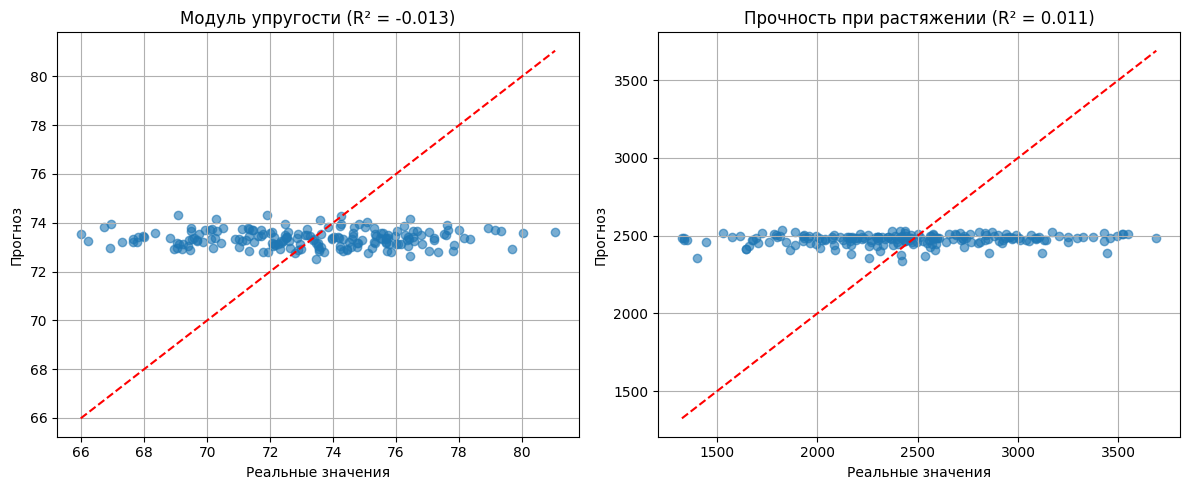

In [58]:
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.scatter(y_test_inv[:, 0], mlp_pred[:, 0], alpha=0.6)
plt.plot([min(y_test_inv[:, 0]), max(y_test_inv[:, 0])],
         [min(y_test_inv[:, 0]), max(y_test_inv[:, 0])], 'r--')
plt.title(f'Модуль упругости (R² = {r2_modulus:.3f})')
plt.xlabel('Реальные значения')
plt.ylabel('Прогноз')
plt.grid(True)

plt.subplot(1, 2, 2)
plt.scatter(y_test_inv[:, 1], mlp_pred[:, 1], alpha=0.6)
plt.plot([min(y_test_inv[:, 1]), max(y_test_inv[:, 1])],
         [min(y_test_inv[:, 1]), max(y_test_inv[:, 1])], 'r--')
plt.title(f'Прочность при растяжении (R² = {r2_strength:.3f})')
plt.xlabel('Реальные значения')
plt.ylabel('Прогноз')
plt.grid(True)

plt.tight_layout()
plt.savefig('r2_visualization.png', dpi=300)
plt.show()

# Нейроная сеть, которая будет рекомендовать соотношение матрица-наполнитель.



# Подготовка данных


In [59]:
X = data.drop(columns=['Соотношение матрица-наполнитель'])
y = data['Соотношение матрица-наполнитель']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

 # Масштабирование данных

In [60]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)


# Создание модели нейронной сети


In [61]:
from tensorflow.keras.layers import BatchNormalization, LeakyReLU

model = Sequential([
    Dense(32, input_shape=(X_train_scaled.shape[1],)),
    BatchNormalization(),
    LeakyReLU(alpha=0.1),
    Dropout(0.2),
    Dense(32),
    BatchNormalization(),
    LeakyReLU(alpha=0.1),
    Dense(1)
])
model.summary()

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/usr/local/lib/python3.11/dist-packages/keras/src/layers/activations/leaky_relu.py:41: UserWarning: Argument `alpha` is deprecated. Use `negative_slope` instead.
  warnings.warn(


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_5 (Dense)                 │ (None, 32)             │           416 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 32)             │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu (LeakyReLU)         │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 32)             │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_1 (LeakyReLU)       │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,761 (6.88 KB)

 Trainable params: 1,633 (6.38 KB)

 Non-trainable params: 128 (512.00 B)

# Компиляция модели


In [62]:
model.compile(optimizer=Adam(learning_rate=0.001),
              loss='mse',
              metrics=['mae'])

# Обучение с ранней остановкой


In [63]:
early_stop = EarlyStopping(monitor='val_loss', patience=20, restore_best_weights=True)
history = model.fit(X_train_scaled, y_train,
                    epochs=200,
                    batch_size=32,
                    validation_split=0.2,
                    callbacks=[early_stop],
                    verbose=1)

Epoch 1/200
19/19 ━━━━━━━━━━━━━━━━━━━━ 4s 34ms/step - loss: 9.2684 - mae: 2.8580 - val_loss: 8.1728 - val_mae: 2.6703
Epoch 2/200
19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 7.1069 - mae: 2.4858 - val_loss: 7.0434 - val_mae: 2.4513
Epoch 3/200
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 5.6939 - mae: 2.1913 - val_loss: 6.0881 - val_mae: 2.2471
Epoch 4/200
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 4.7190 - mae: 1.9442 - val_loss: 5.2647 - val_mae: 2.0524
Epoch 5/200
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 3.3580 - mae: 1.6032 - val_loss: 4.6243 - val_mae: 1.8884
Epoch 6/200
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 2.8632 - mae: 1.4475 - val_loss: 4.0060 - val_mae: 1.7244
Epoch 7/200
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 1.9496 - mae: 1.1879 - val_loss: 3.4991 - val_mae: 1.5834
Epoch 8/200
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 1.6261 - mae: 1.0618 - val_loss: 3.1452 - val_mae: 1.4744
Epoch 9/200
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 1.33

# Оценка модели


In [64]:
y_pred = model.predict(X_test_scaled).flatten()
print(f"MAE: {mean_absolute_error(y_test, y_pred):.4f}")
print(f"R2: {r2_score(y_test, y_pred):.4f}")


6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step
MAE: 0.7380
R2: -0.1775


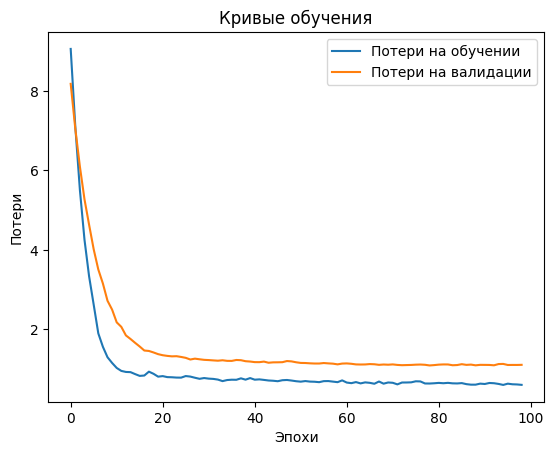

In [65]:
plt.plot(history.history['loss'], label='Потери на обучении')
plt.plot(history.history['val_loss'], label='Потери на валидации')
plt.title('Кривые обучения')
plt.xlabel('Эпохи')
plt.ylabel('Потери')
plt.legend()
plt.show()


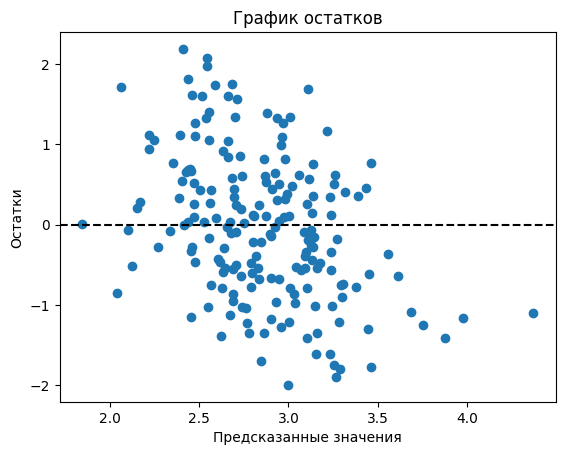

In [66]:
residuals = y_test - y_pred
plt.scatter(y_pred, residuals)
plt.axhline(y=0, color='black', linestyle='--')
plt.title('График остатков')
plt.xlabel('Предсказанные значения')
plt.ylabel('Остатки')
plt.show()


# Сохранение модели


In [67]:
import joblib

mlp_model.save('composite_properties_model.keras')  # Используем новый формат .keras
model.save('matrix_ratio_model.keras')

joblib.dump(scaler_X, 'composite_scaler_X.pkl')
joblib.dump(scaler_y, 'composite_scaler_y.pkl')
joblib.dump(features, 'composite_features.pkl')

joblib.dump(scaler, 'matrix_ratio_scaler.pkl')
matrix_ratio_features = list(data.columns)
matrix_ratio_features.remove('Соотношение матрица-наполнитель')
joblib.dump(matrix_ratio_features, 'matrix_ratio_features.pkl')

['matrix_ratio_features.pkl']

In [68]:
import joblib
import numpy as np
import pandas as pd
from tensorflow.keras.models import load_model

def load_composite_models():
    model = load_model('composite_properties_model.keras')
    scaler_X = joblib.load('composite_scaler_X.pkl')
    scaler_y = joblib.load('composite_scaler_y.pkl')
    features = joblib.load('composite_features.pkl')
    return model, scaler_X, scaler_y, features

def load_matrix_ratio_model():
    model = load_model('matrix_ratio_model.keras')
    scaler = joblib.load('matrix_ratio_scaler.pkl')
    features = joblib.load('matrix_ratio_features.pkl')
    return model, scaler, features

def predict_composite_properties(input_data):
    model, scaler_X, scaler_y, features = load_composite_models()


    input_df = pd.DataFrame([input_data])
    input_df = input_df[features]
    scaled_input = scaler_X.transform(input_df)

    scaled_predictions = model.predict(scaled_input)
    predictions = scaler_y.inverse_transform(scaled_predictions)

    return {
        'Модуль упругости при растяжении, ГПа': predictions[0][0],
        'Прочность при растяжении, МПа': predictions[0][1]
    }

def predict_matrix_ratio(input_data):
    model, scaler, features = load_matrix_ratio_model()

    input_df = pd.DataFrame([input_data])
    input_df = input_df[features]
    scaled_input = scaler.transform(input_df)

    prediction = model.predict(scaled_input)[0][0]
    return {'Соотношение матрица-наполнитель': prediction}


In [69]:
composite_input = {
        'Угол нашивки, град': 1,
        'Шаг нашивки': 12,
        'Плотность нашивки': 45,
        'Соотношение матрица-наполнитель': 0.75,
        'Плотность, кг/м3': 1750,
        'модуль упругости, ГПа': 22.5,
        'Количество отвердителя, м.%': 27,
        'Содержание эпоксидных групп,%_2': 15,
        'Температура вспышки, С_2': 250,
        'Поверхностная плотность, г/м2': 300,
        'Потребление смолы, г/м2': 120
    }
matrix_ratio_input = {
        'Угол нашивки, град': 1,
        'Шаг нашивки': 12,
        'Плотность нашивки': 45,
        'Плотность, кг/м3': 1750,
        'модуль упругости, ГПа': 22.5,
        'Количество отвердителя, м.%': 27,
        'Содержание эпоксидных групп,%_2': 15,
        'Температура вспышки, С_2': 250,
        'Поверхностная плотность, г/м2': 300,
        'Потребление смолы, г/м2': 120,
        'Модуль упругости при растяжении, ГПа': 120,
        'Прочность при растяжении, МПа': 2500
}

composite_result = predict_composite_properties(composite_input)
ratio_result = predict_matrix_ratio(matrix_ratio_input)

print("Предсказанные свойства композита:")
for prop, value in composite_result.items():
    print(f"{prop}: {value:.2f}")

print("\nПредсказанное соотношение матрица-наполнитель:")
print(f"{ratio_result['Соотношение матрица-наполнитель']:.4f}")

/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 261ms/step


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 225ms/step
Предсказанные свойства композита:
Модуль упругости при растяжении, ГПа: 73.28
Прочность при растяжении, МПа: 2435.84

Предсказанное соотношение матрица-наполнитель:
1.9158
